# Traveling Salesman Problem

INSTANCE: Graph $G=\left(V,E\right)$, a collection $C=\{(a_1,b_1),\ldots,(a_m,b_m)\}$ of pairs of vertices from V
SOLUTION: A simple path from s to f in G that contains one node from each pair in C. 
MEASURE: Cost of the path, i.e., the sum of weights of the edges.

Variable: $x_{i,j} = 1$ if the edge (i,j) belongs to the path, 0 otherwise.

The Dantzig–Fulkerson–Johnson formulation is:
$$
\begin{align}
\min &\sum_{i=1}^n \sum_{j\ne i,j=1}^nc_{ij}x_{ij}\colon &&  \\
     & \sum_{i=1,i\ne j}^n x_{ij} = 1 && j=1, \ldots, n; (1)\\
     & \sum_{j=1,j\ne i}^n x_{ij} = 1 && i=1, \ldots, n; (2)\\
     & \sum_{i \in Q}{\sum_{j \ne i, j \in Q}{x_{ij}}} \leq |Q|-1 && \forall Q \subsetneq \{1, \ldots, n\}, |Q| \geq 2 (3)\\
\end{align}
$$

 - (1) : Ensure that a path arrives at j
 - (2) : Ensure that a path leaves i
 - (3) : Subtours elimination

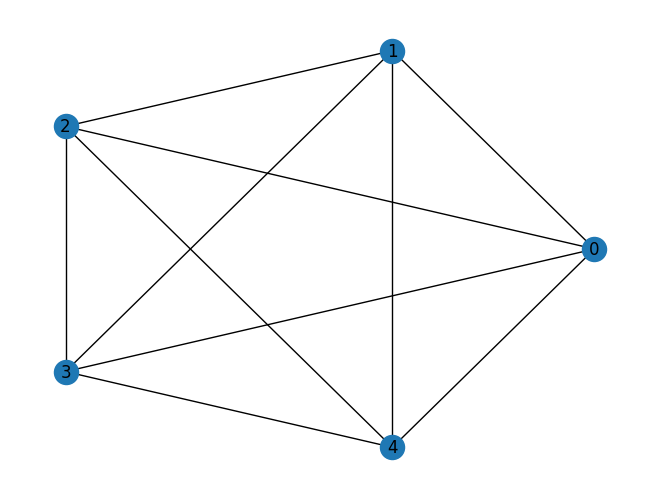

In [1]:
from pyomo.environ import *
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

N = range(5)

roads = [(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]

G.add_edges_from(roads)

nx.draw_circular(G, with_labels=True)

In [2]:
c = {(0, 1): 2, (0, 2): 9, (0, 3): 10, (0, 4): 7, (1, 2): 1, (1, 3): 6, (1, 4): 8, (2, 3): 3, (2, 4): 2, (3, 4): 5}

model = ConcreteModel()

# Variable binaire pour représenter si le trajet entre la ville i et la ville j est emprunté
model.x = Var(N, N, within=Binary)

# Fonction objectif : minimiser la distance totale
model.obj = Objective(expr=sum(c[i, j] * model.x[i, j] for i in N for j in N if (i,j) in roads), sense=minimize)

# Contraintes de flow
model.out_degree = ConstraintList()
for i in N:
    model.out_degree.add(sum(model.x[i, j] for j in N if i != j) == 1)

model.in_degree = ConstraintList()
for i in N:
    model.in_degree.add(sum(model.x[j, i] for j in N if i != j) == 1)

solver = SolverFactory('cbc')
solver.solve(model)

{'Problem': [{'Name': 'unknown', 'Lower bound': 4.0, 'Upper bound': 4.0, 'Number of objectives': 1, 'Number of constraints': 10, 'Number of variables': 20, 'Number of binary variables': 20, 'Number of integer variables': 20, 'Number of nonzeros': 10, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 0.04, 'Wallclock time': 0.04, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}, 'Black box': {'Number of iterations': 0}}, 'Error rc': 0, 'Time': 0.2479250431060791}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

Distance totale minimale : 4.0
Trajet optimal :


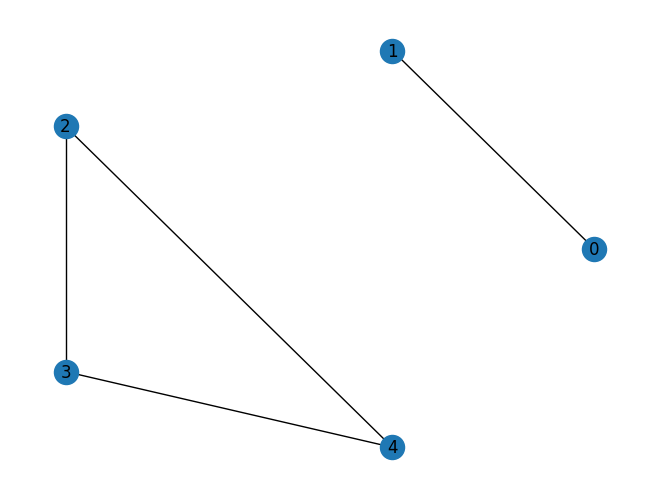

In [3]:
# Afficher la solution
print("Distance totale minimale :", value(model.obj()))
print("Trajet optimal :")
G = nx.Graph()

for r in roads:
    if model.x[r]() or model.x[r[::-1]]():
        G.add_edge(*r)

nx.draw_circular(G, with_labels=True)

In [6]:
model = ConcreteModel()

model.x = Var(N, N, within=Binary)
model.obj = Objective(expr=sum(c[i, j] * model.x[i, j] for i in N for j in N if (i,j) in roads), sense=minimize)

model.out_degree = ConstraintList()
for i in N:
    model.out_degree.add(sum(model.x[i, j] for j in N if i != j) == 1)

model.in_degree = ConstraintList()
for i in N:
    model.in_degree.add(sum(model.x[j, i] for j in N if i != j) == 1)

# Contrainte d'élimination de sous-tour (MTZ)
model.subtour_elimination = ConstraintList()

solver = SolverFactory('cbc')

while True:
    results = solver.solve(model)
    
    if not (results.solver.status == SolverStatus.ok):
        break
        
    G = nx.Graph()

    for r in roads:
        if model.x[r]() or model.x[r[::-1]]():
            G.add_edge(*r)
    
    if nx.is_connected(G):
        break
        
    for nodes in nx.connected_components(G):
        size = len(nodes)
        if size >= 2:
            model.subtour_elimination.add(sum([model.x[i,j] for i in nodes for j in nodes if i != j]) <= size - 1)

Distance totale minimale : 5.0
Trajet optimal :


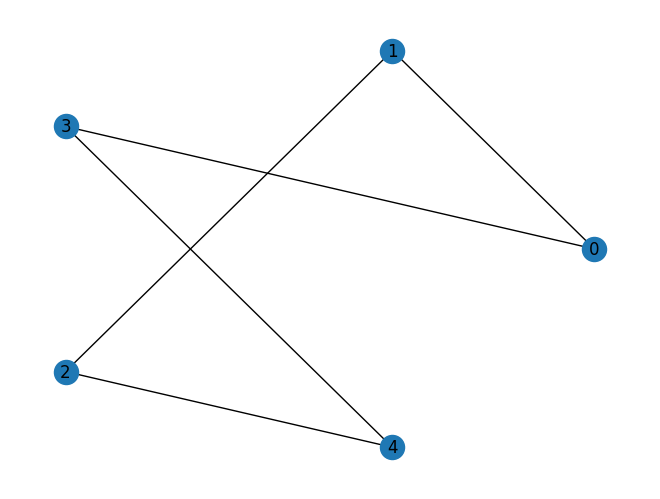

In [7]:
# Afficher la solution
print("Distance totale minimale :", value(model.obj()))
print("Trajet optimal :")
G = nx.Graph()

for r in roads:
    if model.x[r]() or model.x[r[::-1]]():
        G.add_edge(*r)

nx.draw_circular(G, with_labels=True)